<a href="https://colab.research.google.com/github/devleoespinosa/LLM_Curso/blob/main/ejercicio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

In [3]:
#IMPLEMENTACIÓN DE DATASET WikiANN

from datasets import get_dataset_config_names

xtreme_subjects = get_dataset_config_names("xtreme")
print(len(xtreme_subjects))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


183


In [4]:
panx_subjects = [s for s in xtreme_subjects if s.startswith("PAN")]
panx_subjects[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [5]:
from datasets import load_dataset
load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [6]:
from collections import defaultdict
from datasets import DatasetDict
#Definición de fracciones e idiomas
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
  for split in ds:
    panx_ch[lang][split] = (ds[split].shuffle(seed=0).select(range(int(frac*ds[split].num_rows))))

In [7]:
#Averiguar número de ejemplos por idioma

import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, index=["Number of examples"])

,de,fr,it,en
Number of examples,12580,4580,1680,1180


In [8]:
#Uso de Alemán como ejemplo por mayoría de corpus de texto

element = panx_ch["de"]["train"][0]
for key, value in element.items():
  print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [9]:
for key, value in panx_ch["de"]["train"].features.items():
  print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [10]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [11]:
#Asignar una columna para las etiquetas

def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

In [12]:
#Visualización

de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [13]:
#Calcular la frecuencia de las etiquetas

from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith("B"):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [14]:
#TOKENIZADOR

from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"


bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [15]:
#Ejemplo que uso cada tokenizador de una secuencia

text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

bert_tokens, xlmr_tokens

(['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]'],
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

In [16]:
"".join(xlmr_tokens).replace(u"\u2581"," ")

'<s> Jack Sparrow loves New York!</s>'

-----------------------------------------------------------


#CREACIÓN DE UN MODELO DE CLASIFICACIÓN

In [17]:
#Se aplicará el modelo de ROBERTA con ajustes de XLM-R

#Objeto para inicializar el modelo y forward para generar salidas


import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel


class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels

    self.roberta = RobertaModel(config, add_pooling_layer=False) #Cuerpo del modelo, nota: add_pooling_layer es falso para obener todos los tokens y no solo CLS

    #Configuración de la cabeza de clasificación
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    self.init_weights()


  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    #Utiliza el cuerpo del modelo para obtener las representaciones codificadas
    kwargs.pop("num_items_in_batch", None)
    outputs = self.roberta(input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids, **kwargs)

    #Aplicar la clasificación
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)

    #Métricas
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    #Salida del modelo - objetos

    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [18]:
# CARGAR MODELO

#Cargar las etiquetas que se utilizarán

index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [19]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)
xlmr_config

#Gracias al AutoConfig, al realizar from_pretrained el fichero y su configuración se descarga automáticamente

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [20]:
# Carga de los pesos del modelo

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#Comprobación de que el tokenizador y el modelo fue inicializado correctamente

input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index = ['Tokens', 'Input IDs'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [22]:
#Obtener sus puntuaciones

outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
outputs.shape, predictions.shape

(torch.Size([1, 10, 7]), torch.Size([1, 10]))

In [23]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=['Tokens', 'Predicted Tags'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Predicted Tags,B-PER,B-LOC,B-LOC,B-PER,B-LOC,B-LOC,B-PER,B-LOC,B-LOC,B-PER


In [24]:
#ENCAPSULAR EN UNA FUNCIÓN

def tag_text(text, tag, model, tokenizer):
  tokens = tokenizer(text).tokens() # Change here to call .tokens()
  input_ids = xlmr_tokenizer(text, return_tensors="pt")['input_ids'].to(device)
  outputs = model(input_ids)[0]
  predictions = torch.argmax(outputs, dim=2)
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index=['Tokens', 'Predicted Tags'])

In [25]:
#TOKENIZACIÓN PARA EL MODELO XLM-R

words, labels = de_example["tokens"], de_example["ner_tags"]

tokenized_input = xlmr_tokenizer(words, is_split_into_words=True) #Is_split es para referenciar que las sentencias ya fueron divididas en palabras
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

pd.DataFrame([tokens, labels], index=['Tokens', 'Labels'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Labels,0,0,0,0,5,6,0,0,5,5,...,None,None,None,None,None,None,None,None,None,None


In [26]:
#Enmascarar subpalabras
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=['Tokens', ' Word IDs'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [27]:
#Anezando un label id -100 para tokens especiales

previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [28]:
#Encapsular todo en una función

#El propósito es tokenizar datos etiquetados y alinearlos a las etiquetas

def tokenize_and_align_labels(examples):
    #Tokenización
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) #truncation se refiere a que se trunque si excede la longitud máxima
    labels = []

    #Ajuste
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx) #Devuelve una lista donde cada elemento indica a qué palabra pertenece cada token

        #Ajuste tokens especiales
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [29]:
#Aplicar una función para iterar

def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])

In [30]:
#Aplicarlo para el idioma aleman

panx_de = encode_panx_dataset(panx_ch['de'])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [31]:
#APLICAMOS MEDICIÓN DE DESEMPEÑO

#Utilizamos seqeval para tareas de NER

!pip install seqeval

In [32]:
from seqeval.metrics import classification_report

#Ejemplos de aplicación

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [33]:
#Función para integrar al entrenamiento e ignorar labels ID subsecuentes a palabras


import numpy as np


def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2) #Para cada predicción hay distintas probabilidades para cada clase, se toma el de mayor probabilidad.
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []


  #Iteración de cada oración
  for batch_idx in range(batch_size):
      example_labels, example_preds = [], []
      #Iteración de cada token de la oración.
      for seq_idx in range(seq_len):
          # Ignorar los ínidices de tokens especiales o subsecuentes.
          if label_ids[batch_idx, seq_idx] != -100: #Ignorar los tokens especiales
              example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
              example_preds.append(index2tag[preds[batch_idx][seq_idx]])
      #Almacenar las etiquetas
      labels_list.append(example_labels)
      preds_list.append(example_preds)

  return preds_list, labels_list




In [34]:
#FINE-TUNING Y ENTRENAMIENTO

#Definimos la configuración del entrenamiento

from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de["train"]) // batch_size #Determina cada cuantas iteraciones se registra información en el entrenamiento
model_name = f"{xlmr_model_name}-finetuned-panx-de"
#Construcción de los argumentos

training_args = TrainingArguments(
    output_dir=model_name, log_level = 'error', #Carpeta de guardado del modelo
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size, #Número de ejemplos por lote en entrenamiento
    per_device_eval_batch_size=batch_size, #Número de ejemplos por lote en evaluación
    evaluation_strategy="epoch", #Evaluar al final de cada época
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
#Iniciar sesión

from huggingface_hub import notebook_login
notebook_login()

In [36]:
#Calculo de métricas

from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}



In [37]:
# Cotejador de datos

from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=xlmr_tokenizer)



In [38]:
#Función para cargar modelos sin entrenamiento

def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config))

In [39]:
#Entrenamiento

from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de["train"], eval_dataset=panx_de["validation"])

In [38]:

#Entrenamiento

from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de["train"], eval_dataset=panx_de["validation"])


trainer.train()
trainer.push_to_hub(commit_message="Training complete")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: devleoespinosa (devleoespinosa-universidad-aut-noma-de-yucat-n) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,F1
1,0.256800,0.150298,0.826911
2,0.127700,0.139320,0.847726
3,0.081100,0.137332,0.865386


events.out.tfevents.1740239320.2c5917319f2b.1429.0:   0%|          | 0.00/7.36k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/devleoespinosa/xlm-roberta-base-finetuned-panx-de/commit/312a6f14c8b5057272e7c319c32ec6091b630df5', commit_message='Training complete', commit_description='', oid='312a6f14c8b5057272e7c319c32ec6091b630df5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/devleoespinosa/xlm-roberta-base-finetuned-panx-de', endpoint='https://huggingface.co', repo_type='model', repo_id='devleoespinosa/xlm-roberta-base-finetuned-panx-de'), pr_revision=None, pr_num=None)

In [41]:
#PRUEBA

text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"

tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Predicted Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [40]:
#ANÁLISIS DE ERRORES. Implementar un método de validación.

from torch.nn.functional import cross_entropy #Para calcular pérdida con entropía cruzada.

def forward_pass_with_label(batch):

    #Convierte en una lista de diccionarios donde cada elemento representa un conjunto de características.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    batch = data_collator(features)

    #Mover al GPU
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)


    with torch.no_grad(): #Para evitar calcular gradientes y ahorrar memoria en inferencia.
        output = trainer.model(input_ids, attention_mask)
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy() #Obtener la predicción.

    #Cálculo de pérdida.
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1), reduction="none")
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}


In [41]:
#Carga de Datos

valid_set = panx_de["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [46]:
#Lectura de resultados

index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0065036067, 0.0, 0.006841449, 0.005567...","[B-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [47]:
#Analizar tokens de manera individual

df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.31,B-LOC,▁Luz
1,10,1,I-ORG,1.39,I-LOC,▁a


In [49]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁),▁(,▁und,▁A,▁''
count,6066,989,1388,808,163,246,246,1171,125,2898
mean,0.03,0.12,0.09,0.14,0.62,0.32,0.31,0.06,0.49,0.02
sum,208.7,122.75,122.41,113.31,101.02,77.64,76.28,66.31,61.06,51.45


In [50]:
#Por tokens

(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.66,0.58,0.48,0.36,0.27,0.19,0.03
sum,969.19,1552.56,1826.63,1130.57,773.98,767.87,1443.56


In [44]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

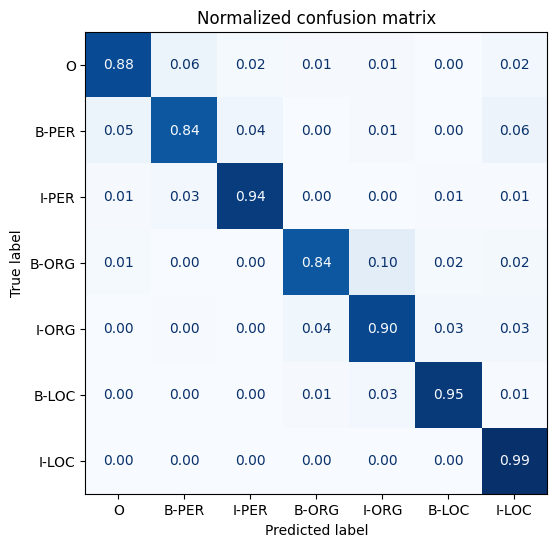

In [52]:
#Matriz de confusión de etiquetas

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

In [43]:
#TRANSFERENCIA A OTROS IDIOMAS


def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]



In [55]:
#Ejemplo de desempeño con alemán

f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.865


In [56]:
#Aplicado a otro idioma

text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Predicted Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [42]:
#Análisis de rendimiento

def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [58]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.701


In [59]:
#Análisis en inglés

f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.583


In [60]:
#Análisis en Italiano

f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.684


In [45]:
#Función para entrenar en un subcojunto de datos // Para entrenar modelos en idiomas que tenían corpus menores

def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size # Cambio en los argumentos, tamaño


    #Actualización del trainer
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [46]:
#Ejemplificación para el frances

panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

In [47]:
#Recuperando modelo

from transformers import AutoModelForTokenClassification

model_ner = "devleoespinosa/xlm-roberta-base-finetuned-panx-de"
model = AutoModelForTokenClassification.from_pretrained(model_ner)

In [48]:
training_args.push_to_hub = False
hub_model_id=model_ner
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

<ipython-input-45-9350caf76030>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: devleoespinosa (devleoespinosa-universidad-aut-noma-de-yucat-n) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,F1
1,1.570300,1.272398,0.000000
2,1.192000,1.019191,0.175123
3,0.970600,0.905155,0.324799


,num_samples,f1_score
0,250,0.336836


In [50]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat([metrics_df, train_on_subset(panx_fr_encoded, num_samples)], ignore_index=True)

<ipython-input-45-9350caf76030>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,1.379100,0.980194,0.335256
2,0.826500,0.632331,0.617299
3,0.555000,0.544818,0.661673


<ipython-input-45-9350caf76030>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,1.042400,0.525314,0.663483
2,0.445600,0.410414,0.727449
3,0.287200,0.377434,0.771283


<ipython-input-45-9350caf76030>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.791900,0.411643,0.697851
2,0.310900,0.344036,0.785384
3,0.221600,0.336569,0.803456


<ipython-input-45-9350caf76030>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.572600,0.362610,0.770443
2,0.276000,0.286203,0.822781
3,0.180800,0.283326,0.829342


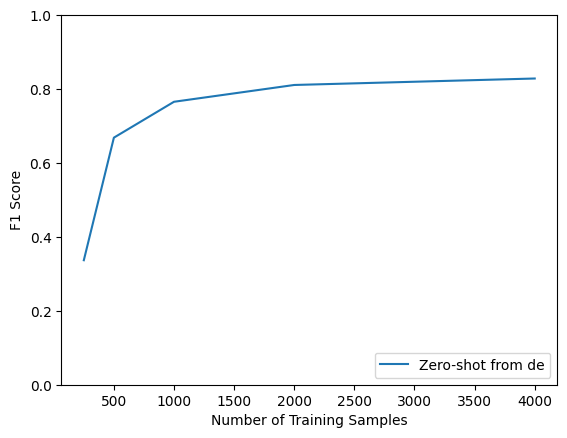

In [54]:
fig, ax = plt.subplots()
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()